In [19]:
# !pip install 'tensorflow==1.14.0'
# !pip install 'tensorflow==1.15.0'
# !pip install 'tensorflow-gpu==1.15'  # GPU
# !pip install 'keras==2.0.8'
# !pip install rasterio

## Reading Images

In [5]:
import cv2
path_1 = "/content/drive/My Drive/Mask_RCNN/Cloud_Dataset/train/satellite1.jpg"
path_2 = "/content/drive/My Drive/Mask_RCNN/Cloud_Dataset/train/satellite2.jpg"
path_3 = "/content/drive/My Drive/Mask_RCNN/Cloud_Dataset/train/satellite3.jpg"
path_4 = "/content/drive/My Drive/Mask_RCNN/Cloud_Dataset/train/satellite4.jpg"
path_5 = "/content/drive/My Drive/Mask_RCNN/Cloud_Dataset/train/satellite5.jpg"
img_1 = cv2.imread(path_1)
# plt.imshow(img_1)
img_2 = cv2.imread(path_2)
img_3 = cv2.imread(path_3)
img_4 = cv2.imread(path_4)
path = "/content/drive/My Drive/tif/3DIMG_07NOV2019_0000_L1C_SGP.tif"

## Convert TIF to JPG

In [36]:
os.chdir("/content/drive/My Drive")
import cv2
import math
import rasterio
import matplotlib.pyplot as plt
import os

def conversion(tifFilePath,ColortoSaveAs):
    sat_data = rasterio.open(tifFilePath)
    b = sat_data.read(1)
    fig = plt.imshow(b,cmap="gray")
    #plt.colorbar()
    # plt.show()
    plt.savefig(ColortoSaveAs)


## Cloud Detection with Mask RCNN

[INFO] loading Mask R-CNN model...
Re-starting from epoch 8
[INFO] making predictions with Mask R-CNN...
Processing 1 images
image                    shape: (341, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
0:00:15.172658
{'0': {'x': array([199, 200, 201, ..., 205, 206, 207]), 'y': array([ 43,  43,  43, ..., 184, 184, 184])}}
{'0': {'x': array([199, 200, 201, ..., 205, 206, 207]), 'y': array([ 43,  43,  43, ..., 184, 184, 184])}, '1': {'x': array([379, 380, 381, ..., 353, 359, 360]), 'y': array([222, 222, 222, ..., 293, 293, 293])}}
{'0': {'x': array([199, 200, 201, ..., 205, 206, 207]), 'y': array([ 43,  43,  43, ..., 184, 184, 184])}, '1': {'x': array([379, 380, 381, ..., 353, 359, 360]), 

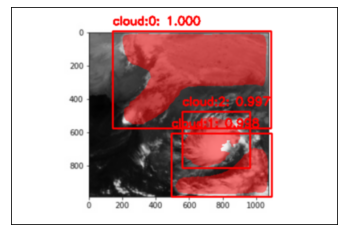

In [43]:
os.chdir('/content/drive/My Drive/Mask_RCNN')
import os
import sys
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
import numpy as np
import colorsys
import argparse
import imutils
import random
import cv2
import os
import datetime
import matplotlib.pyplot as plt
from collections import defaultdict
CLASS_NAMES = open('/content/drive/My Drive/Mask_RCNN/test_mask_rcnn/labels.txt').read().strip().split("\n")

hsv = [(i / len(CLASS_NAMES), 1, 1.0) for i in range(len(CLASS_NAMES))]
COLORS = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
random.seed(42)
random.shuffle(COLORS)

class SimpleConfig(Config):
	NAME = "coco_inference"
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1
	NUM_CLASSES = len(CLASS_NAMES)

config = SimpleConfig()

print("[INFO] loading Mask R-CNN model...")
model = modellib.MaskRCNN(mode="inference", config=config,
	model_dir=os.getcwd())
model.load_weights('/content/drive/My Drive/Mask_RCNN/logs/cloud20200715T1252/mask_rcnn_cloud_0008.h5', by_name=True)

if ('tif' in path):
		output_path = "/content/drive/My Drive/tif_converted/output.jpg"
		conversion(path,output_path)
		image = cv2.imread(output_path)
else:
		image = cv2.imread(path)
# img = cv2.imread(args["image"],0)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = imutils.resize(image, width=512)

now = datetime.datetime.now()
print("[INFO] making predictions with Mask R-CNN...")
r = model.detect([image], verbose=1)[0]
complete = datetime.datetime.now()
print(complete-now)

cloud_coordinates = {}
for i in range(0, r["rois"].shape[0]):
	classID = r["class_ids"][i]
	mask = r["masks"][:, :, i]
	color = COLORS[classID][::-1]
	coordinates = np.where(mask == True)
	x = coordinates[1]
	y = coordinates[0]
	cloud_coordinates[str(i)] = {'x':x,'y':y}
	image = visualize.apply_mask(image, mask, color, alpha=0.5)
	plt.imshow(image, cmap = 'gray', interpolation = 'bicubic')
	print(cloud_coordinates)

image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

count = 0
for i in range(0, len(r["scores"])):
	(startY, startX, endY, endX) = r["rois"][i]
	classID = r["class_ids"][i]
	label = CLASS_NAMES[classID]
	score = r["scores"][i]
	color = [int(c) for c in np.array(COLORS[classID]) * 255]
	cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
	text = "{}:{:}: {:.3f}".format(label,count, score)
	y = startY - 10 if startY - 10 > 10 else startY + 10
	cv2.putText(image, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX,0.6, color,2)
	count = count + 1

com = defaultdict(list)
for i in range(r['rois'].shape[0]):
	l = (r['rois'][i].tolist())
	x = (l[1]+l[3])/2
	y = (l[0]+l[2])/2
	com[i].append(x)
	com[i].append(y)
# print(r['rois'])
# print(r['masks'])
# print(com)
with open("com.txt","a") as f:
	print(com,file=f)
plt.imshow(image, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()


## Cloud Detection with KMeans

0:00:00.534114


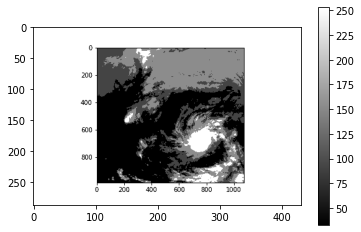

In [48]:
os.chdir("/content/drive/My Drive")
import math

def cloud_detection(timestamp):
    img = cv2.imread(timestamp)
    Z = img.reshape((-1,3))

    # convert to np.float32
    Z = np.float32(Z)

    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 4
    now = datetime.datetime.now()
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    complete = datetime.datetime.now()
    print(complete-now)

    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))
    res2bw = cv2.cvtColor(res2, cv2.COLOR_BGR2GRAY)
    colors = np.unique(res2bw)

    # Removing background, since the darkest color is sky
    colors = colors[1:]
    # print(colors)
    plt.imshow(res2bw, cmap = 'gray')
    plt.colorbar()
    plt.show()  

    com = {}
    for i in range(0, len(colors)):
        filter_mask = (res2bw == colors[i]).astype(int)
        filter_mask = cv2.convertScaleAbs(filter_mask, alpha=(255.0))
        co_ordinates = np.where(filter_mask == 0)
        x = co_ordinates[0]
        y = co_ordinates[1]
        mean_x = np.mean(x)
        mean_y = np.mean(y)
        com[i] = [round(mean_x, 2), round(mean_y, 2)]
    
    return com

if ('tif' in path):
		output_path = "/content/drive/My Drive/tif_converted/output.jpg"
		conversion(path,output_path)
		cloud_detection(output_path)
else:
		cloud_detection(path)


### Cloud Motion Prediction Mean Path Adjustment

1. Let previous CoM positions be: t - 1, t - 2
2. Let at be the actual CoM position at t
3. Predicted mean CoM at t = mean(t - 1, t - 2)
4. Next prediction for t+1 = mean(at, t) + (at-t)

Adopts itself to abrupt changes in cloud positions by:
- Using actual and predicted values for next prediction 
- Correcting its prediction by adding the *errors*

In [45]:
def mean_path_adjustment(com1, com2, com3, com4): 
    predicted = {}
    error = {}
    for cloud_index in range(0, len(com1)):
        x1 = com1[cloud_index][0]
        y1 = com1[cloud_index][1]

        x2 = com2[cloud_index][0]
        y2 = com2[cloud_index][1]

        x3 = com3[cloud_index][0]
        y3 = com3[cloud_index][1]

        x4 = com4[cloud_index][0]
        y4 = com4[cloud_index][1]

        x = (x1 + x2) / 2
        y = (y1 + y2) / 2

        predicted_x4 = ((x + x3) / 2) + (x3 - x)
        predicted_y4 = ((y + y3) / 2) + (y3 - y)

        predicted[cloud_index] = [predicted_x4, predicted_y4]
        error[cloud_index] = round(math.sqrt(pow(abs(predicted_x4 - x4), 2) + pow(abs(predicted_y4 - y4), 2)), 2)

    '''print("Actual COM at t + 1: ", com4)
    print("Predicted COM at t + 1: ", predicted)
    print("Error: ", error)'''
    
    return com4, predicted, error

### Testing MPA


0:00:00.570357


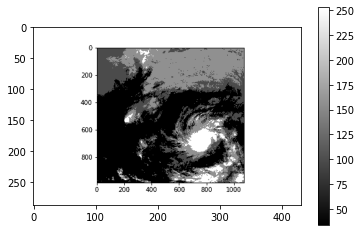

0:00:00.547302


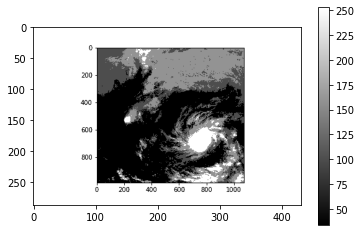

0:00:00.481377


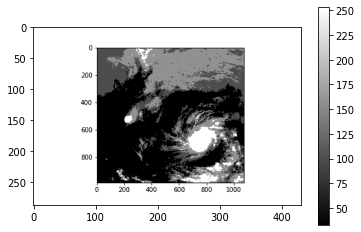

0:00:00.510167


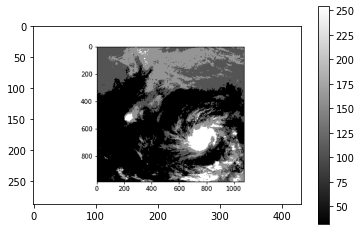

In [49]:
com_dict = {}
error = {}
predicted = {}

if i not in com_dict:
  com_dict[i] = cloud_detection(path_1)
  
if i+1 not in com_dict:
    com_dict[i+1] = cloud_detection(path_2)
  
if i+2 not in com_dict:
    com_dict[i+2] = cloud_detection(path_3)

if i+3 not in com_dict:
    com_dict[i+3] = cloud_detection(path_4)

actual, predicted[i], error[i] = mean_path_adjustment(com_dict[i], com_dict[i+1], com_dict[i+2], com_dict[i+3])

# for i in range(2, 41):
#     # print(i)
#     if i not in com_dict:
#         com_dict[i] = cloud_detection(str(i))
    
#     if i+1 not in com_dict:
#         com_dict[i+1] = cloud_detection(str(i+1))
    
#     if i+2 not in com_dict:
#         com_dict[i+2] = cloud_detection(str(i+2))
    
#     if i+3 not in com_dict:
#         com_dict[i+3] = cloud_detection(str(i+3))
    
#     actual, predicted[i], error[i] = mean_path_adjustment(com_dict[i], com_dict[i+1], com_dict[i+2], com_dict[i+3])

In [51]:
import pandas as pd
df = pd.DataFrame(error)
df
df.mean(axis=1)

0    1.61
1    1.63
2    0.16
dtype: float64

## Cloud Motion Prediction with CNN LSTM






In [66]:
# !pip install keras==2.3.1

     |████████████████████████████████| 378kB 8.3MB/s 
  Found existing installation: Keras 2.0.8
    Uninstalling Keras-2.0.8:
      Successfully uninstalled Keras-2.0.8


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
def get_error(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	s = measure.compare_ssim(imageA, imageB)
	return {"mse": err, "ssim": s}

In [13]:
def predict_motion(t, model):
  """
  This function returns the path where the GIF for current motion
  is saved by the ConvLSTM model.
  :param t: number representing the latest image
  """
  images = []
  for i in range(t-3,t+2):
    img = cv.imread('drive/My Drive/INSAT3D_TIR1_PNG/' + str(i) + '.png',0)
    img = cv.resize(img,(150,150),interpolation=cv.INTER_AREA)
    images.append(img)
    if i != t+1:
      path = 'drive/My Drive/MeghNA_Models/outputs/'+str(i)+'.png'
      plt.imshow(img, cmap='gray')
      plt.axis('off')
      plt.savefig(path)

  output = model.predict(np.array(images[:-1]).reshape(1,4,150,150,1))
  output = output.reshape(150,150)
  print(get_error(np.asarray(images[-1]), output))

  path = 'drive/My Drive/MeghNA_Models/outputs/' + str(t+1) + '.png'
  plt.imshow(output, cmap='gray')
  plt.axis('off')
  plt.savefig(path)
  return path

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


{'mse': 754.6568490188662, 'ssim': 0.5035715879265065}
drive/My Drive/MeghNA_Models/outputs/13.png


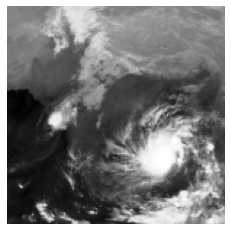

In [14]:
from keras.models import load_model
model = load_model('drive/My Drive/MeghNA_Models/[3CNN_2LSTM_Sequence_4_Size_150_TIR].h5')
path = predict_motion(12, model)
print(path)